In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
from sklearn.impute import SimpleImputer


In [2]:
data = pd.read_csv('train_dataset_final1.csv')
data.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [3]:
# Find columns with missing values
missing_cols = [col for col in data.columns if data[col].isnull().any()]

# Fill missing values with median and count filled values
for col in missing_cols:
    num_missing = data[col].isnull().sum()
    median = data[col].median()
    data[col] = data[col].fillna(median)
    print(f"Filled {num_missing} missing values in column '{col}' with median value {median}.")

Filled 126 missing values in column 'age' with median value 34.0.


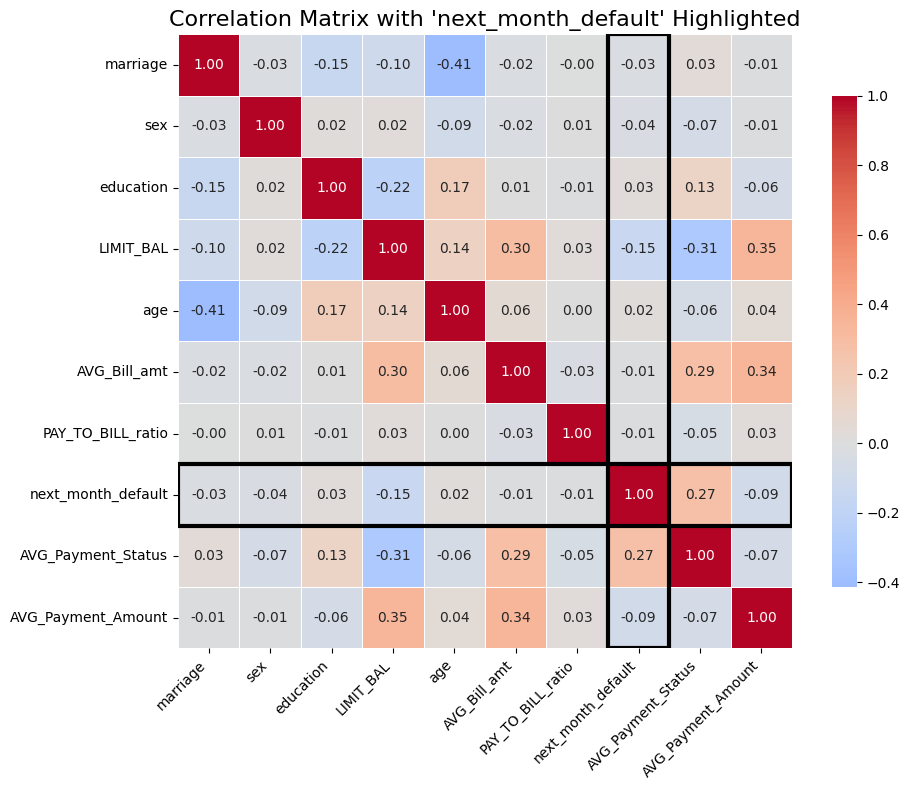

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy original data
df_corr = data.copy()

# Create averaged features
df_corr['AVG_Bill_amt'] = df_corr[[f'Bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
df_corr['AVG_Payment_Status'] = df_corr[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].mean(axis=1)
df_corr['AVG_Payment_Amount'] = df_corr[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)

# Drop unnecessary columns
cols_to_drop = (
    ['Customer_ID'] +
    [f'Bill_amt{i}' for i in range(1, 7)] +
    ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'] +
    [f'pay_amt{i}' for i in range(1, 7)]
)
df_corr_small = df_corr.drop(columns=cols_to_drop, errors='ignore')

# Correlation matrix
corr_matrix = df_corr_small.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                 center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Highlight 'next_month_default' column and row
highlight_label = 'next_month_default'
if highlight_label in corr_matrix.columns:
    idx = list(corr_matrix.columns).index(highlight_label)

    # Draw rectangles to highlight the row and column
    ax.add_patch(plt.Rectangle((idx, 0), 1, len(corr_matrix), fill=False, edgecolor='black', lw=3))
    ax.add_patch(plt.Rectangle((0, idx), len(corr_matrix), 1, fill=False, edgecolor='black', lw=3))

plt.title("Correlation Matrix with 'next_month_default' Highlighted", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
from sklearn.preprocessing import StandardScaler

# Select features and target variable
X = data.drop(['Customer_ID', 'next_month_default'], axis=1)
y = data['next_month_default']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #converted to array

# X_scaled is now ready for linear regression

In [6]:
n = X_scaled.shape[0]
split = int(n * 0.8)
indices = np.random.RandomState(42).permutation(n)
train_idx, test_idx = indices[:split], indices[split:]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y.values[train_idx], y.values[test_idx]

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Add bias term
X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Fit linear regression (normal equation)
w = np.linalg.inv(X_train_b.T @ X_train_b) @ (X_train_b.T @ y_train.reshape(-1, 1))

# Predict and threshold at 0.5
y_pred = X_test_b @ w
y_pred_class = (y_pred >= 0.5).astype(int).flatten()

# Accuracy
acc = (y_pred_class == y_test).mean()
print(f"Test accuracy: {acc:.4f}")

# Other evaluation metrics
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
conf_matrix = confusion_matrix(y_test, y_pred_class)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Test accuracy: 0.8133
Precision: 0.6207
Recall:    0.0742
F1 Score:  0.1325
Confusion Matrix:
[[4035   44]
 [ 899   72]]


In [8]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Prepare features and target
X = data.drop(['Customer_ID', 'next_month_default'], axis=1).values
y = data['next_month_default'].values.reshape(-1, 1)

# Standardize features (manual)
mean = X.mean(axis=0)
std = X.std(axis=0)
X_scaled = (X - mean) / std

# Train-test split (assuming you've already split data)
# For example:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Add bias term
X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Ridge regression closed-form solution
def ridge_weights(X, y, lmbd):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0  # Don't regularize bias
    return np.linalg.inv(X.T @ X + lmbd * I) @ (X.T @ y)

# Cross-validation to find best lambda
lambdas = np.logspace(-3, 3, 10)
best_acc = 0
best_lmbd = None
acc_list = []

for lmbd in lambdas:
    fold_size = X_train.shape[0] // 5
    accs = []
    for fold in range(5):
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size if fold < 4 else X_train.shape[0]
        val_idx = np.arange(val_start, val_end)
        tr_idx = np.setdiff1d(np.arange(X_train.shape[0]), val_idx)
        X_tr, y_tr = X_train_b[tr_idx], y_train[tr_idx]
        X_val, y_val = X_train_b[val_idx], y_train[val_idx]
        w = ridge_weights(X_tr, y_tr, lmbd)
        y_pred = X_val @ w
        y_pred_class = (y_pred >= 0.5).astype(int)
        acc = (y_pred_class.flatten() == y_val.flatten()).mean()
        accs.append(acc)
    mean_acc = np.mean(accs)
    acc_list.append(mean_acc)
    if mean_acc > best_acc:
        best_acc = mean_acc
        best_lmbd = lmbd

# Train on full train set with best lambda
w_best = ridge_weights(X_train_b, y_train, best_lmbd)

# Predict on test set
y_pred_test = X_test_b @ w_best
y_pred_test_class = (y_pred_test >= 0.5).astype(int).flatten()
test_acc = (y_pred_test_class == y_test.flatten()).mean()

# Evaluation metrics
precision = precision_score(y_test, y_pred_test_class)
recall = recall_score(y_test, y_pred_test_class)
f1 = f1_score(y_test, y_pred_test_class)
conf_matrix = confusion_matrix(y_test, y_pred_test_class)

print(f"Best lambda: {best_lmbd}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Plot accuracy vs. lambda
# plt.semilogx(lambdas, acc_list, marker='o')
# plt.xlabel("Lambda")
# plt.ylabel("CV Accuracy")
# plt.title("Ridge Regression: Accuracy vs Lambda")
# plt.grid(True)
# plt.show()


Best lambda: 0.001
Test accuracy: 0.8133
Precision: 0.6207
Recall:    0.0742
F1 Score:  0.1325
Confusion Matrix:
[[4035   44]
 [ 899   72]]


Regression was not overfitting.

In [9]:
# import numpy as np
# from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# # Helper functions for entropy and information gain
# def entropy(y):
#     if len(y) == 0:
#         return 0
#     p1 = np.mean(y)
#     p0 = 1 - p1
#     if p1 == 0 or p1 == 1:
#         return 0
#     return -p0 * np.log2(p0) - p1 * np.log2(p1)

# def info_gain(y, y_left, y_right):
#     n = len(y)
#     n_left = len(y_left)
#     n_right = len(y_right)
#     if n_left == 0 or n_right == 0:
#         return 0
#     return entropy(y) - (n_left / n) * entropy(y_left) - (n_right / n) * entropy(y_right)

# # Decision tree node class
# class Node:
#     def __init__(self, depth=0, max_depth=5):
#         self.left = None
#         self.right = None
#         self.feature = None
#         self.threshold = None
#         self.pred = None
#         self.depth = depth
#         self.max_depth = max_depth

#     def fit(self, X, y):
#         if len(set(y)) == 1 or self.depth >= self.max_depth:
#             self.pred = round(np.mean(y))
#             return

#         n_samples, n_features = X.shape
#         best_gain = -1
#         best_feat = None
#         best_thresh = None

#         for feat in range(n_features):
#             thresholds = np.unique(X[:, feat])
#             for thresh in thresholds:
#                 left_idx = X[:, feat] <= thresh
#                 right_idx = X[:, feat] > thresh
#                 if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
#                     continue
#                 gain = info_gain(y, y[left_idx], y[right_idx])
#                 if gain > best_gain:
#                     best_gain = gain
#                     best_feat = feat
#                     best_thresh = thresh

#         if best_gain == -1:
#             self.pred = round(np.mean(y))
#             return

#         self.feature = best_feat
#         self.threshold = best_thresh

#         left_idx = X[:, self.feature] <= self.threshold
#         right_idx = X[:, self.feature] > self.threshold

#         self.left = Node(depth=self.depth + 1, max_depth=self.max_depth)
#         self.left.fit(X[left_idx], y[left_idx])
#         self.right = Node(depth=self.depth + 1, max_depth=self.max_depth)
#         self.right.fit(X[right_idx], y[right_idx])

#     def predict_one(self, x):
#         if self.pred is not None:
#             return self.pred
#         if x[self.feature] <= self.threshold:
#             return self.left.predict_one(x)
#         else:
#             return self.right.predict_one(x)

#     def predict(self, X):
#         return np.array([self.predict_one(x) for x in X])

# # Train decision tree
# tree = Node(max_depth=5)
# tree.fit(X_train, y_train.flatten())

# # Predict on test set
# y_pred_tree = tree.predict(X_test).astype(int)  # Ensure integer class labels
# y_test_flat = y_test.flatten()
# acc_tree = np.mean(y_pred_tree == y_test_flat)

# # Evaluation
# precision = precision_score(y_test_flat, y_pred_tree)
# recall = recall_score(y_test_flat, y_pred_tree)
# f1 = f1_score(y_test_flat, y_pred_tree)
# conf_matrix = confusion_matrix(y_test_flat, y_pred_tree)

# # Output
# print(f"Decision tree test accuracy: {acc_tree:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall:    {recall:.4f}")
# print(f"F1 Score:  {f1:.4f}")
# print("Confusion Matrix:")
# print(conf_matrix)

In [10]:
# # Simple Random Forest implementation (no sklearn)
# # We'll use the Node class from the previous cell as our decision tree

# class SimpleRandomForest:
#     def __init__(self, n_estimators=10, max_depth=5, max_features='sqrt', random_state=None):
#         self.n_estimators = n_estimators
#         self.max_depth = max_depth
#         self.max_features = max_features
#         self.trees = []
#         self.features_list = []
#         self.random_state = np.random.RandomState(random_state)

#     def _get_max_features(self, n_features):
#         if self.max_features == 'sqrt':
#             return max(1, int(np.sqrt(n_features)))
#         elif self.max_features == 'log2':
#             return max(1, int(np.log2(n_features)))
#         elif isinstance(self.max_features, int):
#             return self.max_features
#         else:
#             return n_features

#     def fit(self, X, y):
#         n_samples, n_features = X.shape
#         for i in range(self.n_estimators):
#             # Bootstrap sample
#             idx = self.random_state.choice(n_samples, n_samples, replace=True)
#             X_sample = X[idx]
#             y_sample = y[idx].flatten()
#             # Random feature selection
#             max_feats = self._get_max_features(n_features)
#             feats = self.random_state.choice(n_features, max_feats, replace=False)
#             self.features_list.append(feats)
#             # Train tree
#             tree = Node(max_depth=self.max_depth)
#             tree.fit(X_sample[:, feats], y_sample)
#             self.trees.append(tree)

#     def predict(self, X):
#         # Aggregate predictions from all trees
#         preds = []
#         for tree, feats in zip(self.trees, self.features_list):
#             pred = tree.predict(X[:, feats])
#             preds.append(pred)
#         preds = np.array(preds)  # shape: (n_estimators, n_samples)
#         # Majority vote
#         maj_vote = np.round(np.mean(preds, axis=0))
#         return maj_vote

# # Train and evaluate
# rf = SimpleRandomForest(n_estimators=10, max_depth=5, max_features='sqrt', random_state=42)
# rf.fit(X_train, y_train.flatten())
# y_pred_rf = rf.predict(X_test)
# acc_rf = np.mean(y_pred_rf == y_test.flatten())
# print(f"Random forest test accuracy: {acc_rf:.4f}")

In [11]:
# Train Random Forest classifier
rf_lib = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=55, class_weight='balanced')
rf_lib.fit(X_train, y_train.flatten())

# Predict
y_pred_rf_lib = rf_lib.predict(X_test)
y_test_flat = y_test.flatten()
acc_rf_lib = np.mean(y_pred_rf_lib == y_test_flat)

# Evaluation metrics
precision = precision_score(y_test_flat, y_pred_rf_lib)
recall = recall_score(y_test_flat, y_pred_rf_lib)
f1 = f1_score(y_test_flat, y_pred_rf_lib)
conf_matrix = confusion_matrix(y_test_flat, y_pred_rf_lib)

# Print results
print(f"RandomForestClassifier (sklearn) test accuracy: {acc_rf_lib:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


RandomForestClassifier (sklearn) test accuracy: 0.7980
Precision: 0.4793
Recall:    0.5829
F1 Score:  0.5260
Confusion Matrix:
[[3464  615]
 [ 405  566]]


[LightGBM] [Info] Number of positive: 3836, number of negative: 16361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3779
[LightGBM] [Info] Number of data points in the train set: 20197, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.189929 -> initscore=-1.450470
[LightGBM] [Info] Start training from score -1.450470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

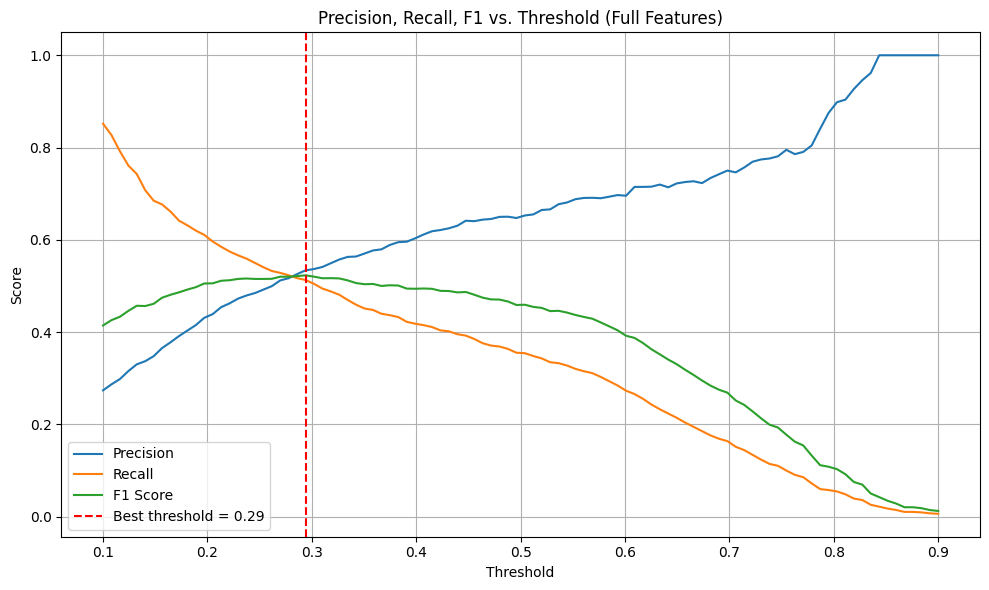


🔎 Best Threshold: 0.29
✅ Accuracy:  0.8202
🎯 Precision: 0.5338
📈 Recall:    0.5129
📊 F1 Score:  0.5231
🧩 Confusion Matrix:
[[3644  435]
 [ 473  498]]


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import lightgbm as lgb

# ✅ Retrain model with full feature set (25 features)
model = lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=55)
model.fit(X_train, y_train)

# ✅ Get predicted probabilities for class 1
y_proba = model.predict_proba(X_test)[:, 1]
y_true = np.ravel(y_test)  # Flatten safely for pandas Series or numpy array

# ✅ Thresholds to evaluate
thresholds = np.linspace(0.1, 0.9, 100)
precisions, recalls, f1s = [], [], []

# ✅ Evaluate metrics at each threshold
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_true, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_true, y_pred_t, zero_division=0))
    f1s.append(f1_score(y_true, y_pred_t, zero_division=0))

# ✅ Find best threshold based on F1 score
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

# ✅ Final prediction using best threshold
y_pred_final = (y_proba >= best_threshold).astype(int)

# ✅ Compute final metrics
precision = precision_score(y_true, y_pred_final)
recall = recall_score(y_true, y_pred_final)
f1 = f1_score(y_true, y_pred_final)
accuracy = accuracy_score(y_true, y_pred_final)
cm = confusion_matrix(y_true, y_pred_final)

# ✅ Plot metrics vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs. Threshold (Full Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Print final results
print(f"\n🔎 Best Threshold: {best_threshold:.2f}")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"📈 Recall:    {recall:.4f}")
print(f"📊 F1 Score:  {f1:.4f}")
print("🧩 Confusion Matrix:")
print(cm)


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:37:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


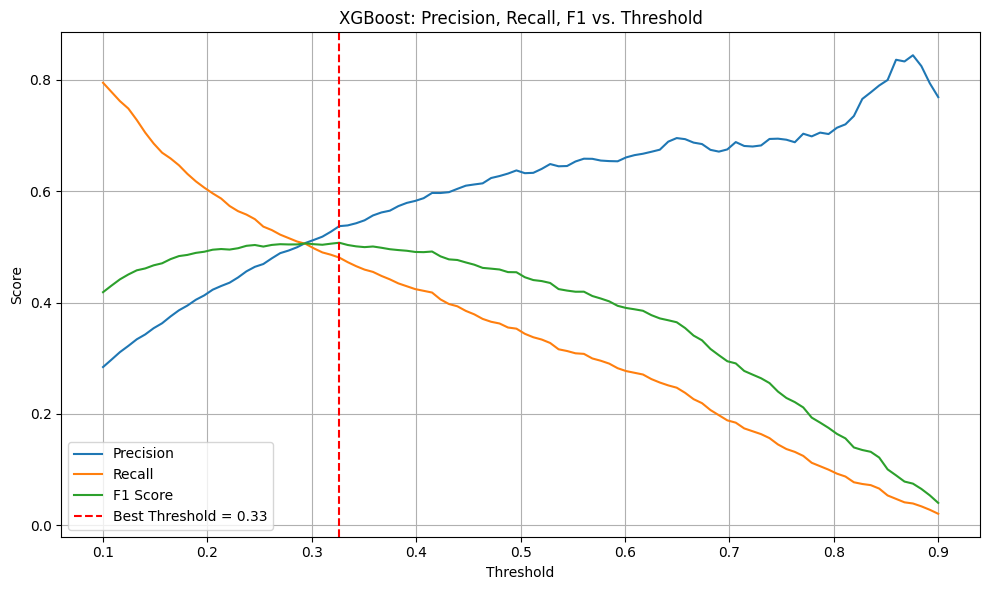


Best Threshold: 0.33
Accuracy:  0.8206
Precision: 0.5374
Recall:    0.4809
F1 Score:  0.5076
Confusion Matrix:
[[3677  402]
 [ 504  467]]


In [13]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# 1. Train XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=90, max_depth=5, random_state=55,
    use_label_encoder=False, eval_metric='logloss'
)
model.fit(X_train, y_train.flatten())

# 2. Predict probabilities for class 1
y_proba = model.predict_proba(X_test)[:, 1]
y_true = y_test.flatten()

# 3. Evaluate metrics over a range of thresholds
thresholds = np.linspace(0.1, 0.9, 100)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_true, y_pred_t))
    recalls.append(recall_score(y_true, y_pred_t))
    f1s.append(f1_score(y_true, y_pred_t))

# 4. Find best threshold based on F1
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

# 5. Final predictions and metrics at best threshold
y_pred_final = (y_proba >= best_threshold).astype(int)
acc = accuracy_score(y_true, y_pred_final)
precision = precision_score(y_true, y_pred_final)
recall = recall_score(y_true, y_pred_final)
f1 = f1_score(y_true, y_pred_final)
cm = confusion_matrix(y_true, y_pred_final)

# 6. Plot metrics vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('XGBoost: Precision, Recall, F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Print final evaluation
print(f"\nBest Threshold: {best_threshold:.2f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
print(cm)


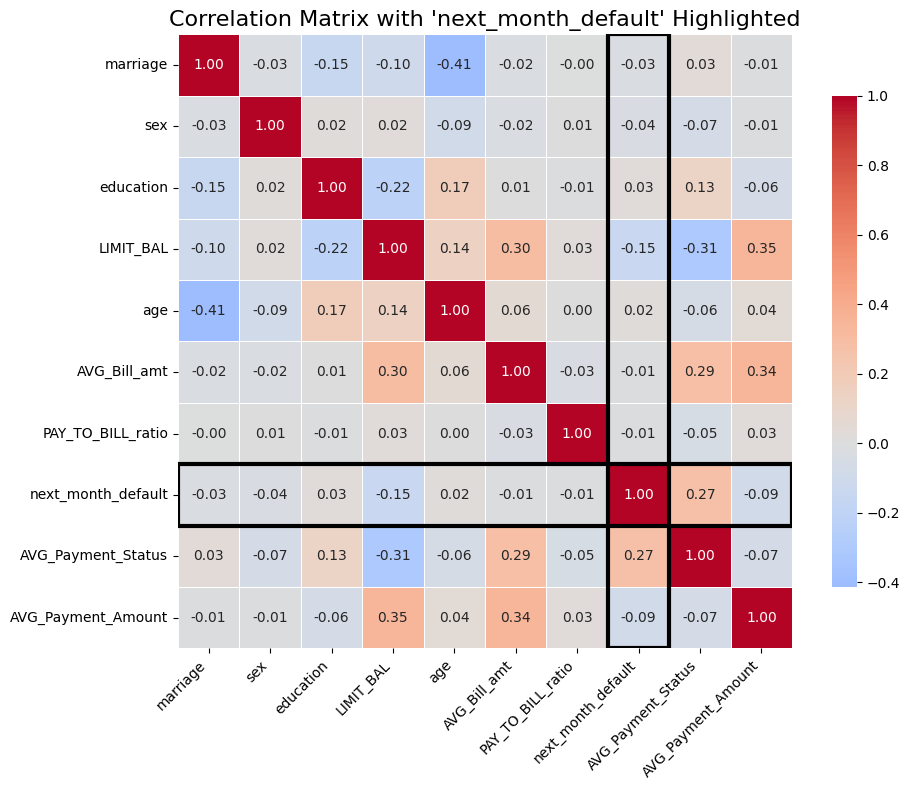

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy original data
df_corr = data.copy()

# Create averaged features
df_corr['AVG_Bill_amt'] = df_corr[[f'Bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
df_corr['AVG_Payment_Status'] = df_corr[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].mean(axis=1)
df_corr['AVG_Payment_Amount'] = df_corr[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)

# Drop unnecessary columns
cols_to_drop = (
    ['Customer_ID'] +
    [f'Bill_amt{i}' for i in range(1, 7)] +
    ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'] +
    [f'pay_amt{i}' for i in range(1, 7)]
)
df_corr_small = df_corr.drop(columns=cols_to_drop, errors='ignore')

# Correlation matrix
corr_matrix = df_corr_small.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                 center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Highlight 'next_month_default' column and row
highlight_label = 'next_month_default'
if highlight_label in corr_matrix.columns:
    idx = list(corr_matrix.columns).index(highlight_label)

    # Draw rectangles to highlight the row and column
    ax.add_patch(plt.Rectangle((idx, 0), 1, len(corr_matrix), fill=False, edgecolor='black', lw=3))
    ax.add_patch(plt.Rectangle((0, idx), len(corr_matrix), 1, fill=False, edgecolor='black', lw=3))

plt.title("Correlation Matrix with 'next_month_default' Highlighted", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


[LightGBM] [Info] Number of positive: 3852, number of negative: 16345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1663
[LightGBM] [Info] Number of data points in the train set: 20197, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.190721 -> initscore=-1.445330
[LightGBM] [Info] Start training from score -1.445330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

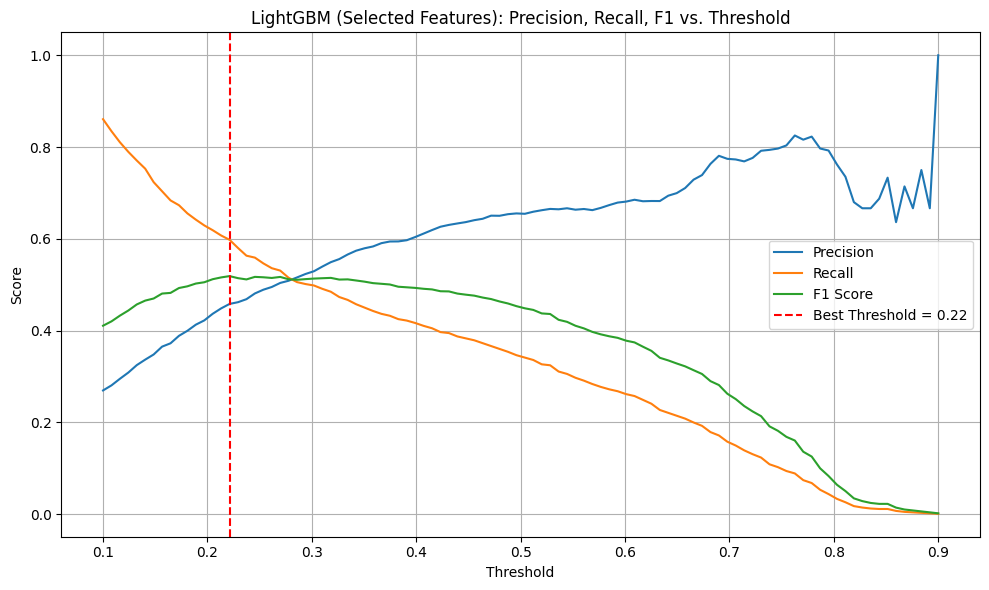


Best Threshold: 0.22
Accuracy:  0.7903
Precision: 0.4583
Recall:    0.5979
F1 Score:  0.5189
Confusion Matrix:
[[3420  675]
 [ 384  571]]


In [15]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from sklearn.model_selection import train_test_split

# Step 1: Exclude specified features
exclude_cols = ['marriage', 'sex', 'education', 'age', 'PAY_TO_BILL_ratio', 'AVG_Bill_amt'] + \
               [f'Bill_amt{i}' for i in range(1, 7)]
feature_cols = [col for col in data.columns if col not in exclude_cols + ['next_month_default', 'Customer_ID']]
X_reduced = data[feature_cols]
y_reduced = data['next_month_default']

# Step 2: Train-test split (80-20)
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

# Step 3: Train LightGBM model
model = lgb.LGBMClassifier(n_estimators=120, max_depth=5, random_state=55)
model.fit(X_train_red, y_train_red)

# Step 4: Predict probabilities
y_proba = model.predict_proba(X_test_red)[:, 1]
y_true = y_test_red.values

# Step 5: Threshold tuning
thresholds = np.linspace(0.1, 0.9, 100)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_true, y_pred_t))
    recalls.append(recall_score(y_true, y_pred_t))
    f1s.append(f1_score(y_true, y_pred_t))

# Step 6: Best threshold
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

# Step 7: Final evaluation at best threshold
y_pred_final = (y_proba >= best_threshold).astype(int)
acc = accuracy_score(y_true, y_pred_final)
precision = precision_score(y_true, y_pred_final)
recall = recall_score(y_true, y_pred_final)
f1 = f1_score(y_true, y_pred_final)
cm = confusion_matrix(y_true, y_pred_final)

# Step 8: Plot metrics vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('LightGBM (Selected Features): Precision, Recall, F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Print final results
print(f"\nBest Threshold: {best_threshold:.2f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
print(cm)


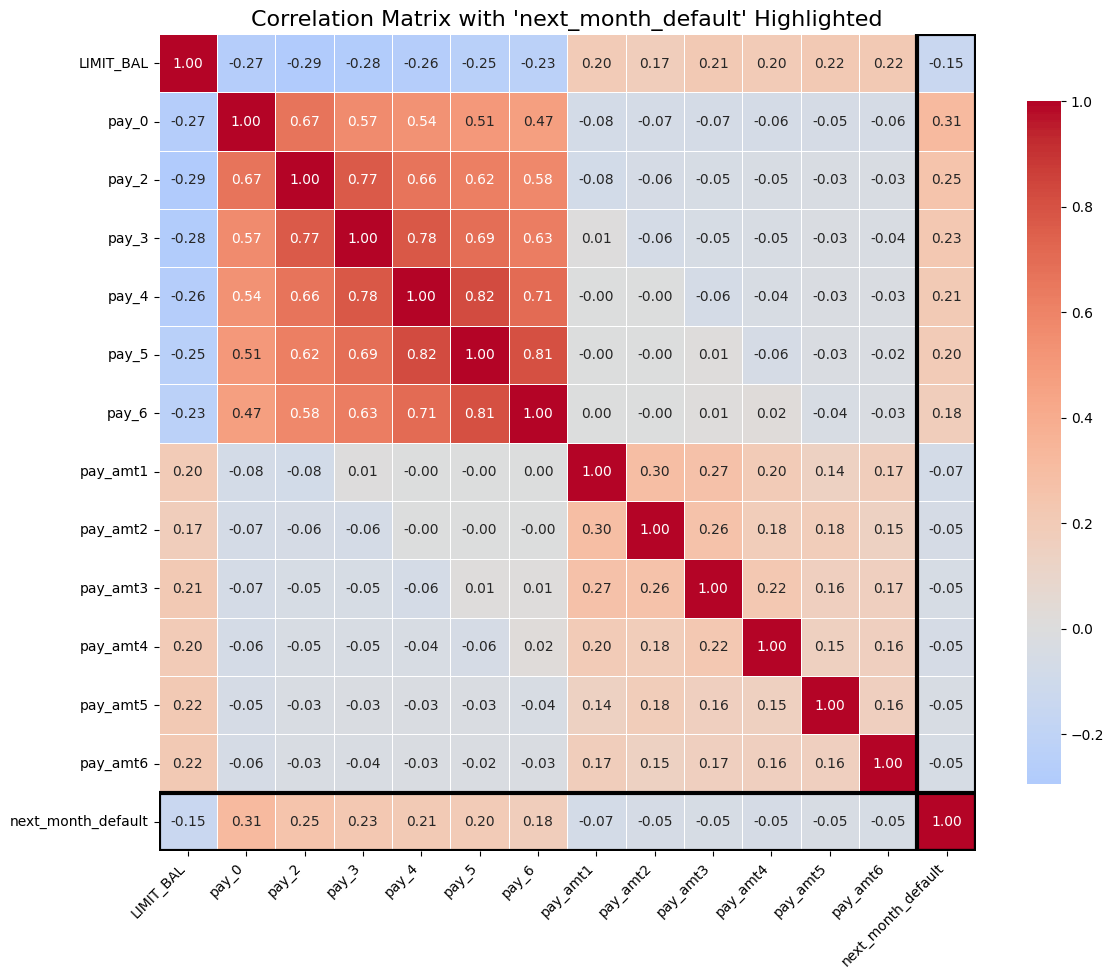

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Define columns to exclude
exclude_cols = ['marriage', 'sex', 'education', 'age', 'PAY_TO_BILL_ratio','AVG_Bill_amt'] + \
               [f'Bill_amt{i}' for i in range(1, 7)] + ['Customer_ID']

# Step 2: Select remaining features (including target)
df_corr = data.drop(columns=exclude_cols, errors='ignore')

# Step 3: Compute correlation matrix
corr_matrix = df_corr.corr()

# Step 4: Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                 center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Step 5: Highlight 'next_month_default' row and column
target_col = 'next_month_default'
if target_col in corr_matrix.columns:
    idx = list(corr_matrix.columns).index(target_col)

    # Draw black rectangle around the column
    ax.add_patch(plt.Rectangle((idx, 0), 1, len(corr_matrix), fill=False, edgecolor='black', lw=3))
    # Draw black rectangle around the row
    ax.add_patch(plt.Rectangle((0, idx), len(corr_matrix), 1, fill=False, edgecolor='black', lw=3))

plt.title("Correlation Matrix with 'next_month_default' Highlighted", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


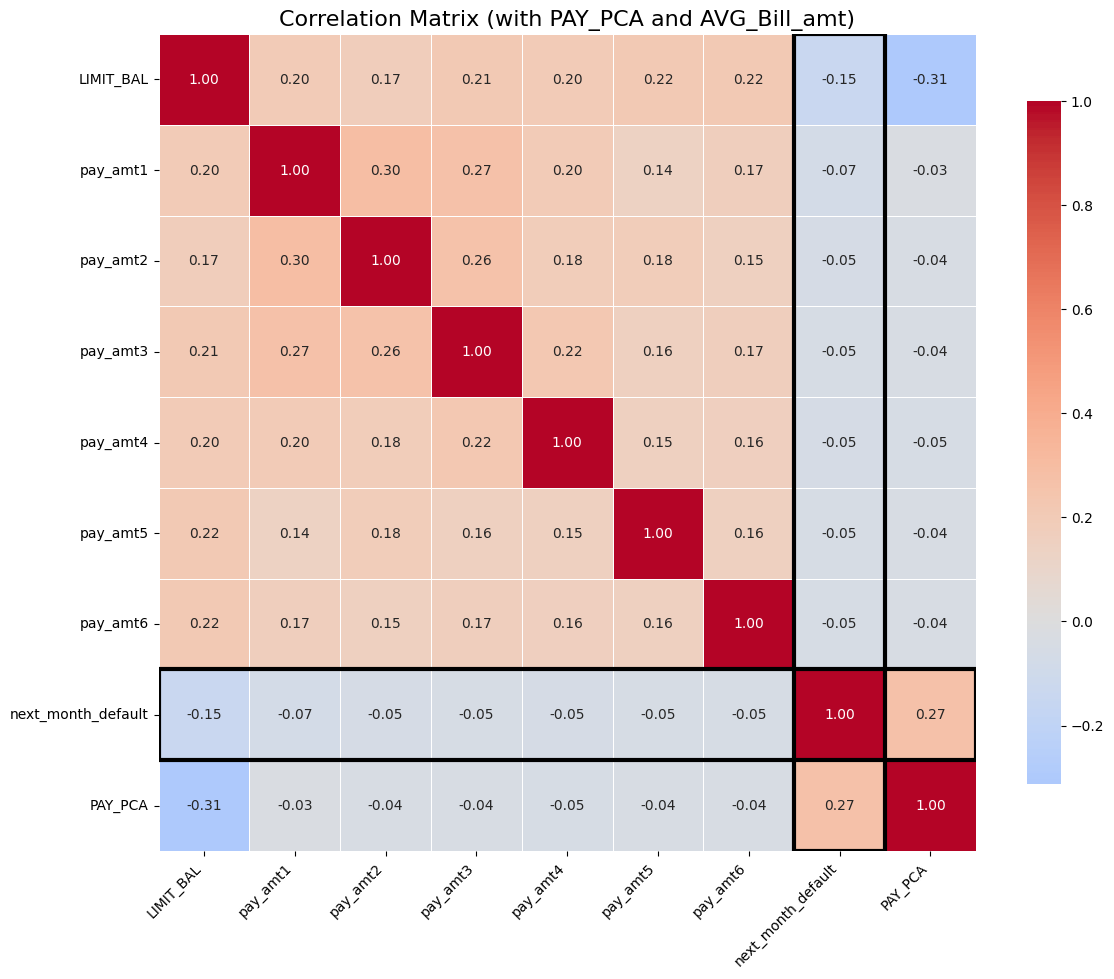

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Create a copy of the original DataFrame
df_corr = data.copy()

# Step 2: Create AVG_Bill_amt
df_corr['AVG_Bill_amt'] = df_corr[[f'Bill_amt{i}' for i in range(1, 7)]].mean(axis=1)

# Step 3: Create PAY_PCA from pay_0 to pay_6 (excluding pay_1 as per original features)
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
scaler = StandardScaler()
pay_scaled = scaler.fit_transform(df_corr[pay_cols])
pca = PCA(n_components=1)
df_corr['PAY_PCA'] = pca.fit_transform(pay_scaled)

# Step 4: Drop excluded features
exclude_cols = ['Customer_ID', 'marriage', 'sex', 'education', 'age', 'PAY_TO_BILL_ratio','AVG_Bill_amt'] + \
               [f'Bill_amt{i}' for i in range(1, 7)] + pay_cols
df_corr = df_corr.drop(columns=exclude_cols, errors='ignore')

# Step 5: Correlation matrix
corr_matrix = df_corr.corr()

# Step 6: Plot heatmap with highlight on target
plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                 center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Highlight 'next_month_default' with black box
target_col = 'next_month_default'
if target_col in corr_matrix.columns:
    idx = list(corr_matrix.columns).index(target_col)
    ax.add_patch(plt.Rectangle((idx, 0), 1, len(corr_matrix), fill=False, edgecolor='black', lw=3))
    ax.add_patch(plt.Rectangle((0, idx), len(corr_matrix), 1, fill=False, edgecolor='black', lw=3))

plt.title("Correlation Matrix (with PAY_PCA and AVG_Bill_amt)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Prepare feature set and label from df_corr
Xr = df_corr.drop(columns=['next_month_default'])
yr = df_corr['next_month_default']

# Step 2: Train-test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)


features_used = list(Xr.columns)
print("Feature List:", features_used)



Feature List: ['LIMIT_BAL', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'PAY_PCA']


[LightGBM] [Info] Number of positive: 3852, number of negative: 16345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 20197, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.190721 -> initscore=-1.445330
[LightGBM] [Info] Start training from score -1.445330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

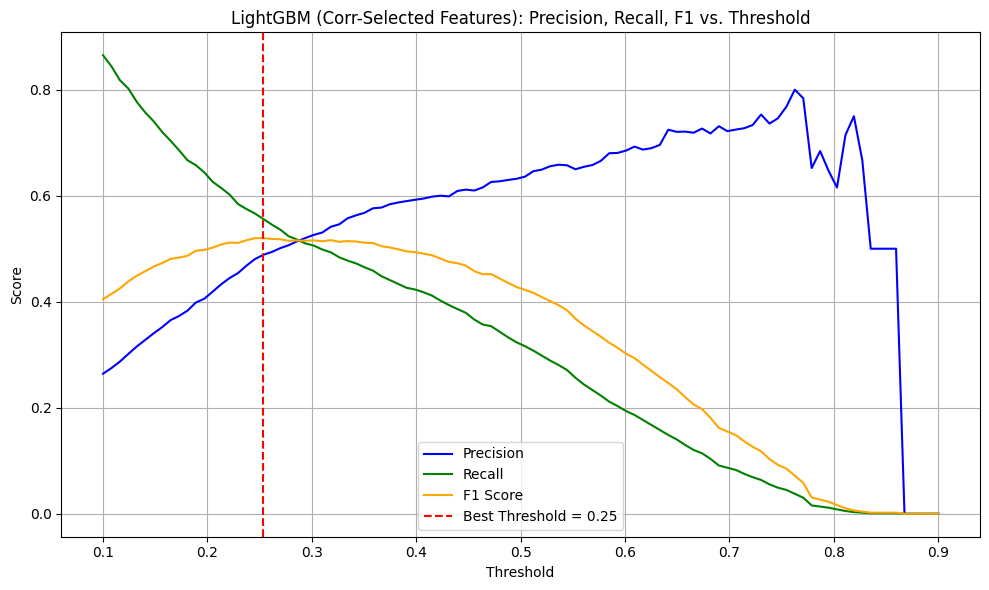


🧠 Best Threshold: 0.25
✅ Accuracy:  0.8059
🎯 Precision: 0.4885
📈 Recall:    0.5560
📊 F1 Score:  0.5201
🔍 Confusion Matrix:
[[3539  556]
 [ 424  531]]


In [19]:
# Step 3: Train LightGBM on correlation-based features
model = lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=55)
model.fit(Xr_train, yr_train)

# Step 4: Predict probabilities
y_proba = model.predict_proba(Xr_test)[:, 1]
y_true = yr_test.to_numpy()  # Fix flatten() error

# Step 5: Threshold tuning based on F1
thresholds = np.linspace(0.1, 0.9, 100)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_true, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_true, y_pred_t, zero_division=0))
    f1s.append(f1_score(y_true, y_pred_t, zero_division=0))

# Step 6: Select best threshold
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

# Step 7: Final prediction & evaluation
y_pred_final = (y_proba >= best_threshold).astype(int)
acc = accuracy_score(y_true, y_pred_final)
precision = precision_score(y_true, y_pred_final)
recall = recall_score(y_true, y_pred_final)
f1 = f1_score(y_true, y_pred_final)
cm = confusion_matrix(y_true, y_pred_final)

# Step 8: Plot metrics vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, f1s, label='F1 Score', color='orange')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('LightGBM (Corr-Selected Features): Precision, Recall, F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Print final metrics
print(f"\n🧠 Best Threshold: {best_threshold:.2f}")
print(f"✅ Accuracy:  {acc:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"📈 Recall:    {recall:.4f}")
print(f"📊 F1 Score:  {f1:.4f}")
print("🔍 Confusion Matrix:")
print(cm)


In [20]:
import time
import lightgbm as lgb
import numpy as np

def average_training_time(X, y, n_runs=10):
    times = []
    for _ in range(n_runs):
        model = lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=55, verbose=-1)
        start = time.time()
        model.fit(X, y)
        end = time.time()
        times.append(end - start)
    return np.mean(times)

n_runs = 10
avg_time_24 = average_training_time(X_train, y_train, n_runs)
avg_time_13 = average_training_time(X_train_red, y_train_red, n_runs)
avg_time_8 = average_training_time(Xr_train, yr_train, n_runs)

print(f"Average time with 24 features over {n_runs} runs: {avg_time_24:.4f} seconds")
print(f"Average time with 13 features over {n_runs} runs: {avg_time_13:.4f} seconds")
print(f"Average time with 8 features over {n_runs} runs: {avg_time_8:.4f} seconds")

print(f"Speed-up 13 features vs 24 features: {avg_time_24 / avg_time_13:.2f}x faster")
print(f"Speed-up 8 features vs 24 features: {avg_time_24 / avg_time_8:.2f}x faster")


Average time with 24 features over 10 runs: 0.1092 seconds
Average time with 13 features over 10 runs: 0.0816 seconds
Average time with 8 features over 10 runs: 0.0608 seconds
Speed-up 13 features vs 24 features: 1.34x faster
Speed-up 8 features vs 24 features: 1.80x faster
